In [1]:
%cd ../tools

/Users/raiota/git/github.com/raiota/Sound-Simulation/tools


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import calculator
import receiver
import source

In [3]:
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'dejavuserif' # math fontの設定
plt.rcParams["font.size"] = 15 # 全体のフォントサイズが変更されます。

# 1. Sound Field Calculaton
点音源による放射音場を計算します．

### 1.1. 各種パラメータの設定
離散化ステップ$0.02 \mathrm{[m]}$，$x \in [0, 4] \mathrm{[m]}$，$y \in [-2, 2] \mathrm{[m]}$，$z=0$の平面について計算します．
対象とする周波数は$600 \mathrm{[Hz]}$とします．このセルでは指定しませんが，音源位置は$(-8, 0, 0)$とします．

In [4]:
STEP = 0.02
X = np.arange(0, 4+STEP, STEP)
Y = np.arange(-2, 2+STEP, STEP)
Z = np.array([0])

FREQS = np.array([600])

## 1.2. 受音点と音源のオブジェクト生成
receiverモジュール内のReceiverParamsクラスを用いて，受音点の一覧を格納したオブジェクトを生成します．<br>
このオブジェクトはpandas.DataFrameを継承し，受音点の情報を属性として保持します．

In [5]:
FIELDS = receiver.ReceiverParams(x=X, y=Y, z=Z, is_meshgrid=True, description='mesh points')

sourceモジュール内のSourceParamsクラスを用いて，音源の一覧を格納したオブジェクトを生成します．<br>
引数のshapeは音源の形状を表し，SourceCategoryクラスを用いて指定します．<br>
このオブジェクトはdict型であり，各音源に整数値の照会番号を割り当てており，それぞれのキーに音源の配置情報を含みます．<br>
また，このdictは音源の情報を属性として保持します．

In [6]:
SOURCE_SHAPE = source.SourceCategory.POINT
POINT_SOURCE = source.SourceParams(shape=SOURCE_SHAPE, source_param_list=np.array([-8., 0, 0]))
print(POINT_SOURCE)

{0: {'x': -8.0, 'y': 0.0, 'z': 0.0}}


## 1.3. 計算ツールのオブジェクト生成および計算の実行
準備した受音点FIELDSと音源POINT_SOURCEを用いて，音圧計算用のオブジェクトを生成します．<br>
これは，calculatorモジュール内のPointSourceFreeFieldCalculatorを用います．<br>
このオブジェクトはget_pressureメソッドで音圧を計算でき，その後にget_SPL，get_amplitude，get_phaseメソッドを用いて，それぞれ音圧レベルと絶対値振幅，位相を計算できます．<br>
いずれも，receiverParamsのDataFrameのインデックス番号に対応した計算結果が格納されたnumpy.ndarrayが返されます．

In [7]:
calctools = calculator.PointSourceFreeFieldCalculator(sources=POINT_SOURCE, receivers=FIELDS, frequency=FREQS)

PRESSURE = calctools.get_pressure()
SPL = calctools.get_SPL()
PHASE = calctools.get_phase()

## 1.4. 可視化

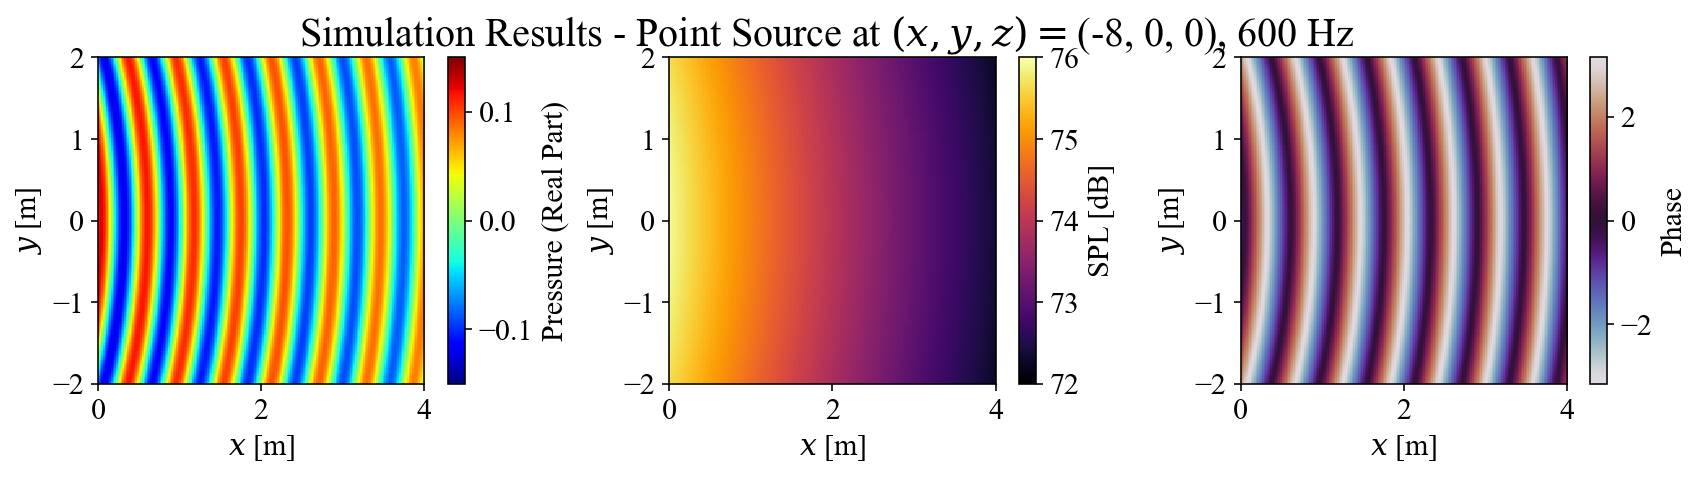

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(14.5, 3))
fig.suptitle(fr'Simulation Results - Point Source at $(x, y, z)=$(-8, 0, 0), {FREQS[0]} Hz', size=20)

im1 = axes[0].pcolorfast(X, Y, PRESSURE[0].real.reshape(X.size, Y.size), vmin=-0.15, vmax=0.15, cmap='jet')
axes[0].set_aspect('equal')
axes[0].set_xlabel(r'$x$ [m]')
axes[0].set_ylabel(r'$y$ [m]')
fig.colorbar(im1, ax=axes[0]).set_label('Pressure (Real Part)')

im2 = axes[1].pcolorfast(X, Y, SPL[0].reshape(X.size, Y.size), vmin=72, vmax=76, cmap='inferno')
axes[1].set_aspect('equal')
axes[1].set_xlabel(r'$x$ [m]')
axes[1].set_ylabel(r'$y$ [m]')
fig.colorbar(im2, ax=axes[1]).set_label('SPL [dB]')

im3 = axes[2].pcolorfast(X, Y, PHASE[0].reshape(X.size, Y.size), cmap='twilight')
axes[2].set_aspect('equal')
axes[2].set_xlabel(r'$x$ [m]')
axes[2].set_ylabel(r'$y$ [m]')
fig.colorbar(im3, ax=axes[2]).set_label('Phase')

fig.subplots_adjust()

# 2. Sound Field Recording and Reproduction

## 2.1. 原音場のシミュレーション

先ほどのシミュレーション結果を原音場とする再生処理を行います．<br>
原音場にマイクロフォンを設置します．ここでも，マイクロフォンの設置にはReceiverParamsクラスを用います．<br>
さて，マイクロフォンは$x \in [1, 2]\mathrm{[m]}, y \in [-0.5, 0.5]\mathrm{[m]}, z \in [-0.5, 0.5]\mathrm{[m]}$の立方体内に，一辺あたり$5$個づつ，合計$125$個のマイクロフォンを設置します．

In [9]:
# Set the microphones
MIC_X = np.linspace(1, 2, 5)
MIC_Y = np.linspace(-0.5, 0.5, 5)
MIC_Z = np.linspace(-0.5, 0.5, 5)

MICS = receiver.ReceiverParams(x=MIC_X, y=MIC_Y, z=MIC_Z, is_meshgrid=True, description='microphones')

計算用オブジェクトcalctoolsにマイクロフォンを設置し，マイクロフォン位置での音圧$\mathbf{p}_{\mathrm{des}}$を求めます．

In [10]:
# Record the desired pressures
calctools.set_receivers(MICS)

P_DES = calctools.get_pressure()

さて，ここで原音場とマイクロフォン位置を可視化しておきます．

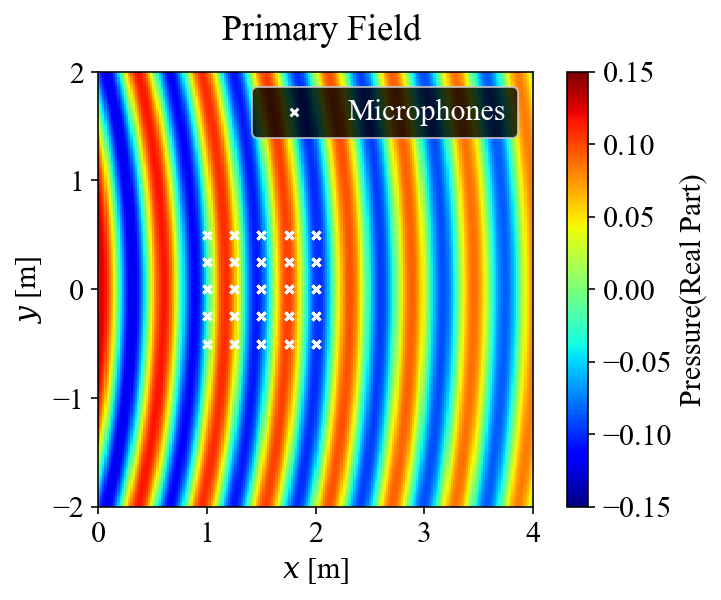

In [11]:
fig, ax = plt.subplots()
fig.suptitle(f'Primary Field')

im = ax.pcolorfast(X, Y, PRESSURE[0].real.reshape(X.size, Y.size), vmin=-0.15, vmax=0.15, cmap='jet')
ax.set_xlabel(r'$x$ [m]')
ax.set_ylabel(r'$y$ [m]')
ax.set_aspect('equal')
fig.colorbar(im).set_label('Pressure(Real Part)')

ax.scatter(MICS.values[:, 0], MICS.values[:, 1], s=15, c='white', marker="x", label='Microphones')

leg = ax.legend(facecolor='black')
for txt in leg.get_texts():
    txt.set_color('white')

## 2.2. 二次音源を用いた音場再生
二次音場にスピーカを置いて，原音場を再現します．<br>
二次音源位置は以下の3種類を挙げておきますが，本シミュレーションでは一番下のものを用いることとします．

In [12]:
# 1. Set the circular loudspeakers
SPEAKER_NUM = 32
SPEAKERS = source.SourceParams(SOURCE_SHAPE)

SPEAKERS.define_sources_on_spherical(source_num=SPEAKER_NUM, centre=np.array([2, 0, 0]), r=1.75,
                                     azimuthes=np.linspace(0, 2*np.pi, SPEAKER_NUM, endpoint=False), elevations=np.pi*.5*np.ones(SPEAKER_NUM))

In [13]:
# 2. Set the linear speaker array
SPEAKER_NUM  = 10
SPEAKERS = source.SourceParams(SOURCE_SHAPE)

SPEAKERS.define_sources_on_line(source_num=SPEAKER_NUM, start_point=np.array([0., -1.0, 0.]), end_point=np.array([0., 1.0, 0.]))

In [14]:
# 3. Set the plane speaker array
SPEAKER_NUM_PER_COLUMN = 5
SPEAKERS = source.SourceParams(SOURCE_SHAPE)

SPEAKERS.define_sources_on_line(source_num=SPEAKER_NUM_PER_COLUMN, start_point=np.array([0., -1.0, 1.5]), end_point=np.array([0., 1.0, 1.5]))
SPEAKERS.define_sources_on_line(source_num=SPEAKER_NUM_PER_COLUMN, start_point=np.array([0., -1.0, 0.75]), end_point=np.array([0., 1.0, 0.75]))
SPEAKERS.define_sources_on_line(source_num=SPEAKER_NUM_PER_COLUMN, start_point=np.array([0., -1.0, 0.]), end_point=np.array([0., 1.0, 0.]))
SPEAKERS.define_sources_on_line(source_num=SPEAKER_NUM_PER_COLUMN, start_point=np.array([0., -1.0, -0.75]), end_point=np.array([0., 1.0, 0.75]))
SPEAKERS.define_sources_on_line(source_num=SPEAKER_NUM_PER_COLUMN, start_point=np.array([0., -1.0, -1.5]), end_point=np.array([0., 1.0, -1.5]))

二次音源と制御点の系を設計します．

In [15]:
# Set the secondary fields
speaker_calculator = calculator.PointSourceFreeFieldCalculator(sources=SPEAKERS, receivers=MICS, frequency=FREQS)

この伝達関数の系の安定性は，伝達関数行列の条件数を用いて計算できます．<br>
安定性とは，変数の摂動に対する解の安定性です．ここでは，対数で表現します．

In [16]:
# Check the condition number for inverse problem
cond_num = np.linalg.cond(speaker_calculator.transfer_matrix)
print(10 * np.log10(cond_num))

[167.07877256]


スピーカの駆動信号を求めます．ここでは多点音圧制御法に基づいた計算を行います．

In [17]:
# Calculate the driving function
DRIVING_MATRIX = speaker_calculator.get_driving_signals_by_pressure_matching(p_des=P_DES, regularize=True, regularization_param=0.01)

二次音源による音場を求めます．先ほどの二次音源と制御点の系を表すオブジェクトに，あらたに音場全体の受音点情報を設定します．

In [18]:
# Compute the secondary fields
speaker_calculator.set_receivers(FIELDS)
P_REP = speaker_calculator.get_pressure(is_driven=True, driving_signals=DRIVING_MATRIX)

二次音場を可視化していきます．

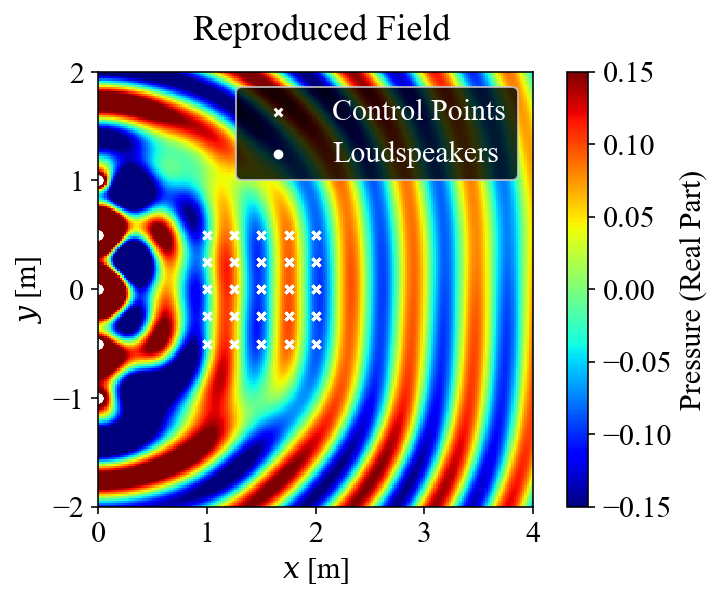

In [19]:
fig, ax = plt.subplots()
fig.suptitle(f'Reproduced Field')

im = ax.pcolorfast(X, Y, P_REP[0].real.reshape(X.size, Y.size), vmin=-0.15, vmax=0.15, cmap='jet')
ax.set_xlabel(r'$x$ [m]')
ax.set_ylabel(r'$y$ [m]')
ax.set_aspect('equal')
fig.colorbar(im).set_label('Pressure (Real Part)')

ax.scatter(MICS.values[:, 0], MICS.values[:, 1], s=15, c='white', marker="x", label='Control Points')
ax.scatter(SPEAKERS.get_arbit_param('x'), SPEAKERS.get_arbit_param('y'), s=15, c='white', marker="o", label='Loudspeakers')

leg = ax.legend(facecolor='black')
for txt in leg.get_texts():
    txt.set_color('white')

正規化誤差分布は以下です．

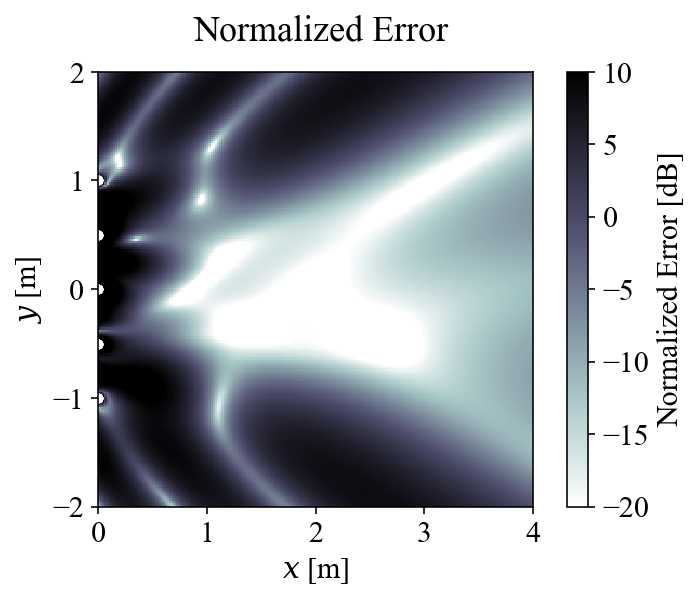

In [20]:
NE = 10 * np.log10(np.abs(PRESSURE - P_REP)**2 / np.abs(PRESSURE)**2)

fig, ax = plt.subplots()
fig.suptitle(f'Normalized Error')

im = ax.pcolorfast(X, Y, NE[0].real.reshape(X.size, Y.size), vmin=10, vmax=-20, cmap='bone_r')
ax.set_xlabel(r'$x$ [m]')
ax.set_ylabel(r'$y$ [m]')
ax.set_aspect('equal')
fig.colorbar(im).set_label('Normalized Error [dB]')

ax.scatter(SPEAKERS.get_arbit_param('x'), SPEAKERS.get_arbit_param('y'), s=15, c='white', marker="o")

## 2.3. 音場再生のためのメソッド
実は今までの動作を一気に行えるためのモジュールがあります．<br>
先ほどと同じことをやってみます．

In [21]:
FIELD_CATEGORY = calculator.FieldCategory.SOURCE
APPROACH = calculator.ReproductionApproach.PRESSURE_MATCHING

reproductor = calculator.ReproductionTool(primary_field_type=FIELD_CATEGORY, primary_source=POINT_SOURCE,
                                          fields=FIELDS, control_points=MICS, secondary_sources=SPEAKERS, frequency=FREQS)

In [22]:
P_REP = reproductor.get_secondary_pressure()

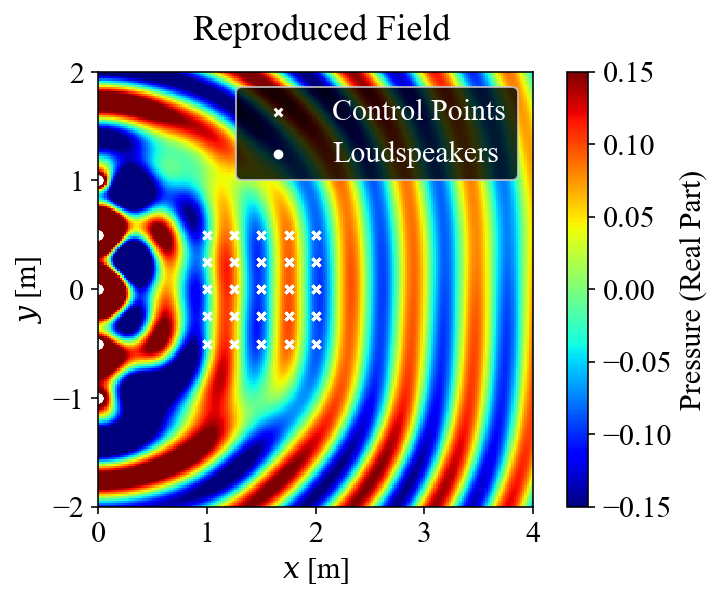

In [23]:
fig, ax = plt.subplots()
fig.suptitle(f'Reproduced Field')

im = ax.pcolorfast(X, Y, P_REP.real.reshape(X.size, Y.size), vmin=-0.15, vmax=0.15, cmap='jet')
ax.set_xlabel(r'$x$ [m]')
ax.set_ylabel(r'$y$ [m]')
ax.set_aspect('equal')
fig.colorbar(im).set_label('Pressure (Real Part)')

ax.scatter(MICS.values[:, 0], MICS.values[:, 1], s=15, c='white', marker="x", label='Control Points')
ax.scatter(SPEAKERS.get_arbit_param('x'), SPEAKERS.get_arbit_param('y'), s=15, c='white', marker="o", label='Loudspeakers')

leg = ax.legend(facecolor='black')
for txt in leg.get_texts():
    txt.set_color('white')

In [24]:
NE = reproductor.get_normalized_error()

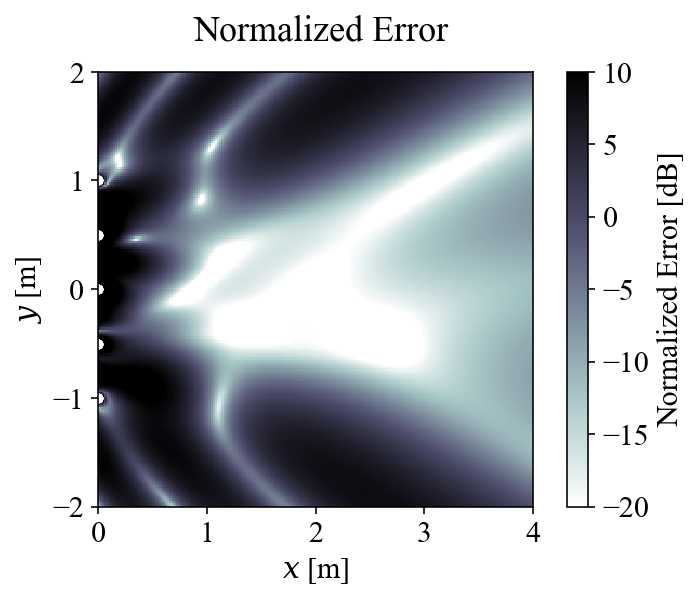

In [25]:
fig, ax = plt.subplots()
fig.suptitle(f'Normalized Error')

im = ax.pcolorfast(X, Y, NE[0].reshape(X.size, Y.size), vmin=10, vmax=-20, cmap='bone_r')
ax.set_xlabel(r'$x$ [m]')
ax.set_ylabel(r'$y$ [m]')
ax.set_aspect('equal')
fig.colorbar(im).set_label('Normalized Error [dB]')

ax.scatter(SPEAKERS.get_arbit_param('x'), SPEAKERS.get_arbit_param('y'), s=15, c='white', marker="o")